<a href="https://colab.research.google.com/github/SibelCakmak/Determination_of_traffic_density_with-drone_images-U-NET-/blob/main/Sementic_Segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DRİVE BAĞLANTISI**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**KÜTÜPHANELERİ KULLANMAK İÇİN GEREKLİ KURUMLAR**

In [ ]:
!pip install te
!pip install tensorflow==2.1
!pip install keras==2.3.1

!pip install -U segmentation-models
!pip install -U --pre segmentation-models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.0 MB/s 
     |████████████████████████████████| 156 kB 10.3 MB/s 
     |████████████████████████████████| 227 kB 60.7 MB/s 
     |████████████████████████████████| 141 kB 43.4 MB/s 
     |████████████████████████████████| 489 kB 47.4 MB/s 
     |████████████████████████████████| 125 kB 49.1 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 22 kB/s 
     |████████████████████████████████| 448 kB 64.3 MB/s 
     |████████████████████████████████| 3.8 MB 41.8 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6d02ccd7d7ef0ec839be9967c00e9a941ae3eff9ac6a83b917bc19a11d6722b5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

**KULLANILACAK KÜTÜPHANELERİ İMPORT ETTİM**

In [ ]:
from tensorflow.keras.utils import normalize
import tensorflow as tf
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random 
from skimage.io import imshow
from PIL import Image
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model


Segmentation Models: using `keras` framework.


Using TensorFlow backend.


**U-NET MİMARİSİ**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

def multiclass_unet_architecture(n_classes=8, height=256, width=256, channels=3):
    inputs = Input((height, width, channels))

    #Contraction path
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)  
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)  
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
     
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D((2, 2))(conv_3)
     
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.1)(conv_4)
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
     
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
    conv_5 = Dropout(0.2)(conv_5)
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)
    

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
    u6 = concatenate([u6, conv_4])
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
    u7 = concatenate([u7, conv_3])
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    conv_7 = Dropout(0.1)(conv_7)
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
    u8 = concatenate([u8, conv_2])
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)  
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    u9 = concatenate([u9, conv_1], axis=3)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model


def jacard(y_true, y_pred):
    y_true_c = K.flatten(y_true)
    y_pred_c = K.flatten(y_pred)
    intersection = K.sum(y_true_c * y_pred_c)
    return (intersection + 1.0) / (K.sum(y_true_c) + K.sum(y_pred_c) - intersection + 1.0) 

def jacard_loss(y_true, y_pred):
    return -jacard(y_true,y_pred)

**VERİ SETİNİ DAHİL ETME VE İŞLEME**

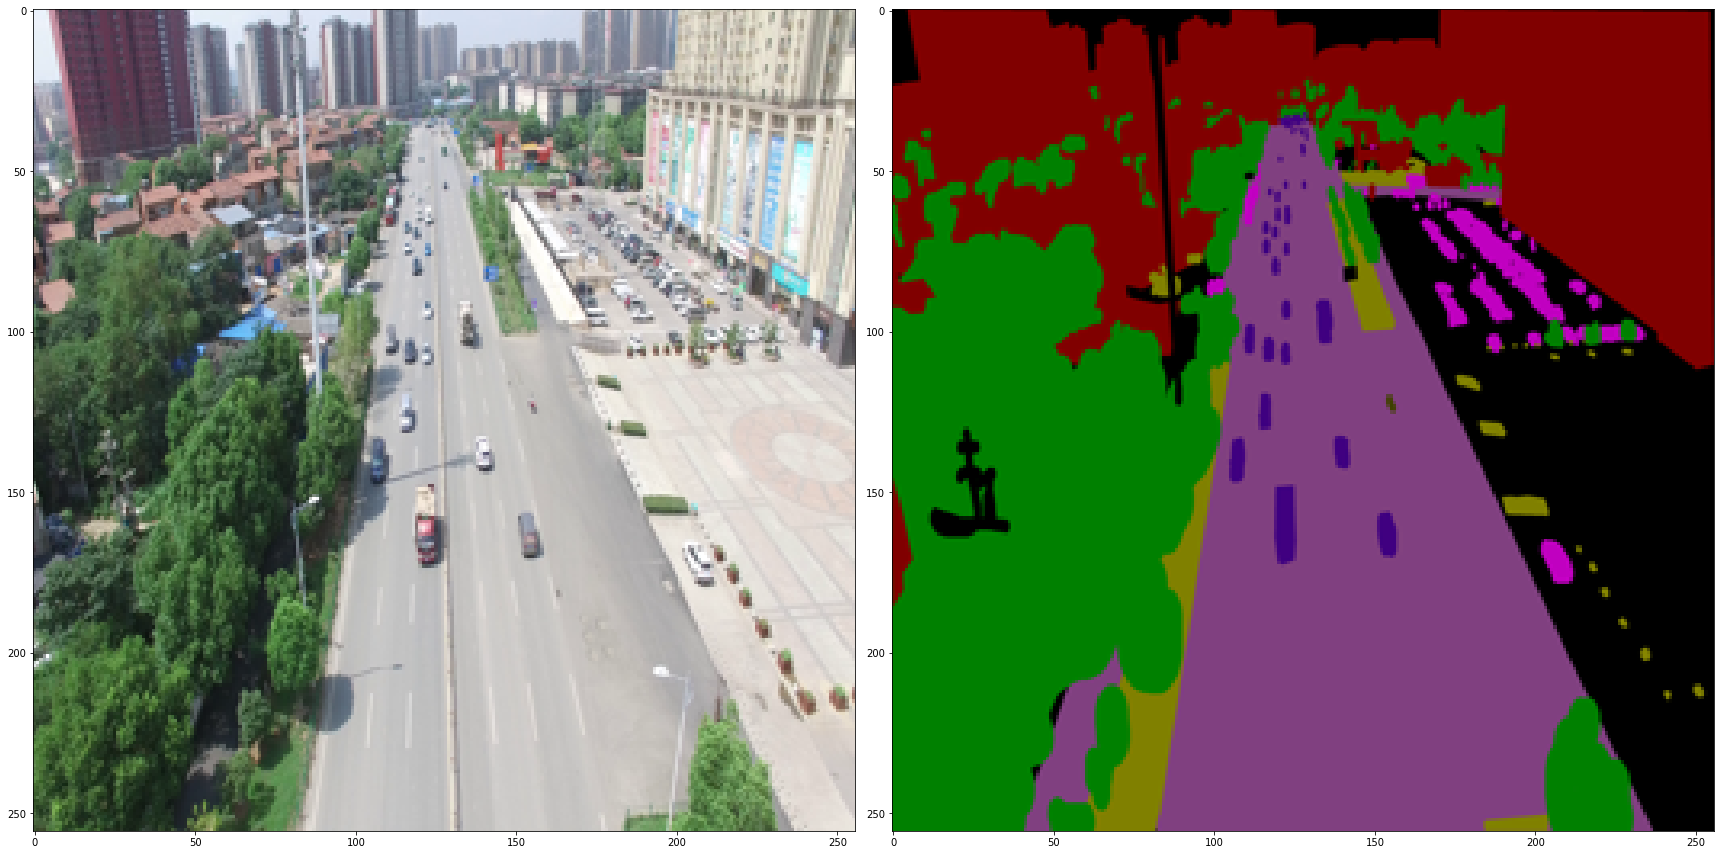

(259, 256, 256, 3)


In [ ]:
def importing_data():
    sample = []
    for filename in range(1,260,1):
        path = "/content/drive/MyDrive/veri/images/"+ str(filename) + ".png"
        img = Image.open(path ,'r')
        img.show()
        img = img.resize((256,256))
        img = np.array(img)
        sample.append(img)  
    return sample


data_train  = importing_data()
data_train = np.asarray(data_train)



def importing_data():
    sample = []
    for filename in range(1,260,1):
        path = "/content/drive/MyDrive/veri/mask/"+ str(filename) + ".png"
        img = Image.open(path ,'r')
        img = img.resize((256,256))
        img = np.array(img)
        sample.append(img)  
    return sample

data_mask   = importing_data()
data_mask  = np.asarray(data_mask)

x = random.randint(0, len(data_train))

plt.figure(figsize=(24,18))
plt.subplot(1,2,1)
imshow(data_train[88])
plt.subplot(1,2,2)
imshow(data_mask[88])
plt.show()

print(data_mask.shape)
scaler = MinMaxScaler()
nsamples, nx, ny, nz = data_train.shape
d2_data_train = data_train.reshape((nsamples,nx*ny*nz))
train_images = scaler.fit_transform(d2_data_train)

train_images = train_images.reshape(259,256,256,3)




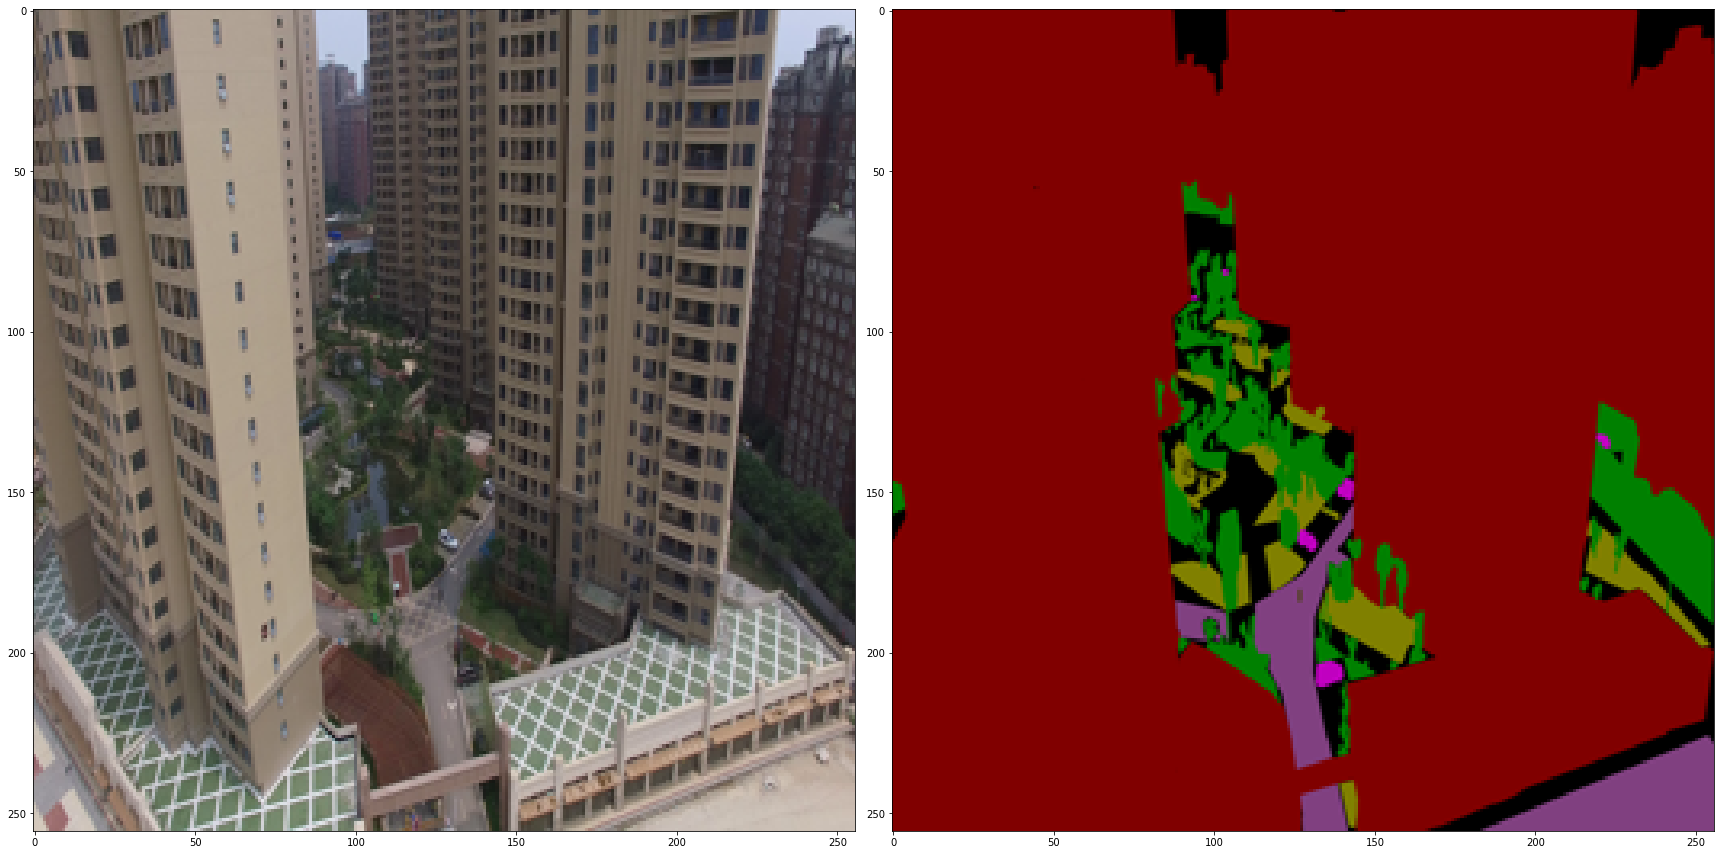

In [ ]:
plt.figure(figsize=(24,18))
plt.subplot(1,2,1)
imshow(data_train[206])
plt.subplot(1,2,2)
imshow(data_mask[206])
plt.show()

**MASKELERİN LABELLERİNİ TANIMLAMA**

In [ ]:
labels = pd.read_csv(r"/content/drive/MyDrive/label.csv")
labels = labels.drop(['name'],axis = 1)
labels = np.array(labels)
print(labels.shape)
def image_labels(label):
    image_labels = np.zeros(label.shape, dtype=np.uint8)
    for i in range(8):
        image_labels [np.all(label == labels[i,:],axis=-1)] = i
    image_labels = image_labels[:,:,0]
    return image_labels


label_final = []
for i in range(data_mask.shape[0]):
    label = image_labels(data_mask[i])
    label_final.append(label)    

label_final = np.array(label_final)   
#%% train_test 

n_classes = len(np.unique(label_final))
labels_cat = to_categorical(label_final, num_classes=n_classes)
x_train, x_test, y_train, y_test = train_test_split(train_images, labels_cat, test_size = 0.20, random_state = 42)

(8, 3)


In [ ]:
# DENEME 


# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)



**VERİ SETİNİN EĞİTİMİ**

In [ ]:
img_height = x_train.shape[1]
img_width  = x_train.shape[2]
img_channels = x_train.shape[3]


metrics=['accuracy', jacard]

def get_model():
    return multiclass_unet_architecture(n_classes=n_classes, height=img_height, 
                           width=img_width, channels=img_channels)

model = get_model()

#optimizer = 'adam' : ) Optimize edici kayıp fonksiyonunun değerine göre sinir ağında kullanılan ağırlıkları günceller. 
# Adam (adaptive moment estimation) :  algoritma stochastic gradient descent’in genişletilmiş halidir.

# Sinir ağının performansını görmek için Metrics argümanı kullanılır.

# loss fonksiyonu sinir ağının eğitim verisi üzerindeki performansını ölçer. Bunu, sinir ağının tahmini ile gerçek değeri karşılaştırarak yapar. İki veya daha fazla sınıfınız olduğunda loss fonksiyonu olarak 
# SparseCategoricalCrossentropy kullanabilirsiniz. Etiketleri one-hot ile kodlamışsanız CategoricalCrossentropy loss’unu kullanabilirsiniz.

# özet
#model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
checkpoint_filepath ='/content/drive/MyDrive/my_best_model.hdf5/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
callbacks = [model_checkpoint_callback]

In [ ]:
history = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks,  
                    shuffle=False)

Train on 207 samples, validate on 52 samples
Epoch 1/10
207/207 [==============================] - 164s 792ms/sample - loss: 1.8575 - accuracy: 0.3006 - jacard: 0.1052 - val_loss: 1.7294 - val_accuracy: 0.3337 - val_jacard: 0.1050
Epoch 2/10
207/207 [==============================] - 158s 763ms/sample - loss: 1.6563 - accuracy: 0.3412 - jacard: 0.1303 - val_loss: 1.5812 - val_accuracy: 0.3341 - val_jacard: 0.1247
Epoch 3/10
207/207 [==============================] - 156s 754ms/sample - loss: 1.5321 - accuracy: 0.3496 - jacard: 0.1530 - val_loss: 1.4766 - val_accuracy: 0.3375 - val_jacard: 0.1426
Epoch 4/10
207/207 [==============================] - 159s 770ms/sample - loss: 1.4639 - accuracy: 0.3623 - jacard: 0.1620 - val_loss: 1.4056 - val_accuracy: 0.3856 - val_jacard: 0.1560
Epoch 5/10
207/207 [==============================] - 156s 755ms/sample - loss: 1.3944 - accuracy: 0.4045 - jacard: 0.1742 - val_loss: 1.2999 - val_accuracy: 0.4208 - val_jacard: 0.1786
Epoch 6/10
207/207 [=====

In [ ]:
from keras.losses import MeanSquaredError
from keras.models import model_from_json
from tensorflow import keras
import json
mse = MeanSquaredError()


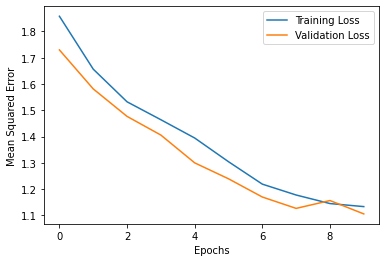

Model MSE on test data =  0.07542536


In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

import json

# lets assume `model` is main model 
model_json = model.to_json()
with open("model_in_json.json", "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights("model_weights.h5")
yhat = model.predict(x_test)
print('Model MSE on test data = ', mse(y_test, yhat).numpy())

In [ ]:
x_test0 = np.reshape(x_test[0],(1,256,256,3))
y_pred=model.predict(x_test0)
print(y_pred)


[[[[3.09092015e-01 2.82820821e-01 5.71746379e-02 ... 3.46066132e-02
    2.96114460e-02 3.57875936e-02]
   [4.39656079e-01 4.23452705e-01 2.56873108e-02 ... 5.69270877e-03
    2.46819039e-03 9.15422104e-03]
   [5.05153120e-01 4.03609633e-01 2.39364952e-02 ... 2.90921563e-03
    1.24312099e-03 5.89270145e-03]
   ...
   [3.27797174e-01 1.86274111e-01 4.62310687e-02 ... 1.74360108e-02
    1.16898799e-02 1.89028811e-02]
   [2.96403557e-01 1.67025104e-01 5.79695515e-02 ... 1.92981660e-02
    1.05204107e-02 2.09454652e-02]
   [2.52090454e-01 1.85076401e-01 8.80111083e-02 ... 4.35962528e-02
    2.42285673e-02 4.28381376e-02]]

  [[4.55168098e-01 3.37984800e-01 7.26466104e-02 ... 9.58554447e-03
    4.83869342e-03 1.40737519e-02]
   [5.41901410e-01 4.12173301e-01 1.75513029e-02 ... 4.73365042e-04
    1.83743454e-04 3.15586617e-03]
   [5.11526108e-01 4.55801964e-01 1.55911902e-02 ... 4.20559052e-04
    7.51281696e-05 9.84573504e-04]
   ...
   [4.25621927e-01 1.94173783e-01 2.24840753e-02 ... 3.37

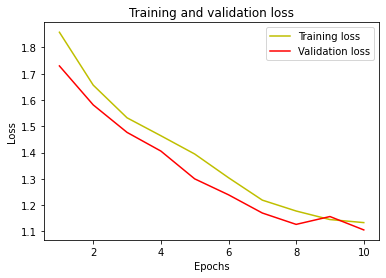

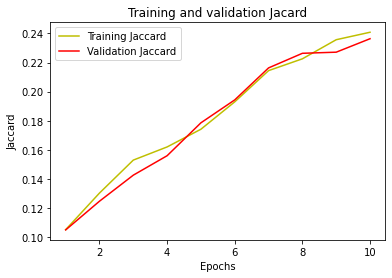

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard']
val_acc = history.history['val_jacard']

plt.plot(epochs, acc, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc, 'r', label='Validation Jaccard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(x_test[1])
print(y_pred)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

test_jacard = jacard(y_test,y_pred)
print(test_jacard)

ValueError: ignored

In [ ]:

fig, ax = plt.subplots(5, 3, figsize = (12,18)) 
for i in range(0,5):
    test_img_number = random.randint(0, len(x_test))
    test_img = x_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number] 
    test_img_input=np.expand_dims(test_img, 0) 
    prediction = (model.predict(test_img_input)) 
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]    
    
    ax[i,0].imshow(test_img)
    ax[i,0].set_title("RGB Image",fontsize=16)
    ax[i,1].imshow(ground_truth)
    ax[i,1].set_title("Ground Truth",fontsize=16)
    ax[i,2].imshow(predicted_img)
    ax[i,2].set_title("Prediction",fontsize=16)
    i+=i
    
plt.show()

In [ ]:
from keras.metrics import MeanIoU
n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
print(y_test.shape)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)